#**CIS 5450 Group Project**#

By Soline Boussard, Isabella Cruz, Aaron Finkelstein

April 26th, 2023

#**Motivation**


In this project, we draw from two datasets in order to provide a comprehensive analysis of the potential link between changes in Earth's surface temperature and country-level carbon dioxide emissions. We focus primarily on temperature and emissions data post-1875 to highlight the decades in which industrial activity began to have a measurable impact on the planet's climate. 

The primary objective of our analysis is to merge temperature data with geographical emissions data in order to display causation between emissions and rising temperatures within a country. In doing so, we develop a series of predictive models that build upon techniques such as linear regression, random forests, and ARIMA forecasting for a time series. 



Our project provides an in-depth look at the evolution of both temperature and carbon dioxide emissions over time, offering a careful comparison of the two in order to reveal underlying relationships. This sort of analysis is crucial in order to understand the global cumulative human impact on climate change, calling attention to the countries with leading pollution levels. Findings could be used to bring a sense of urgency to climate-related action, as well as to direct reduction efforts geographically. 

#**Data Loading and Preprocessing**#

##Imports

In [ ]:
import pandas as pd
import datetime as dt
import matplotlib.image as mpimg
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import cm
import seaborn as sns
import sklearn 
import numpy as np

##Global Land Temperature Data ##

[Link to CSV](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv) (GlobalLandTemperaturesByCity - load to run notebook)

Our first dataset contains average monthly temperatures at the city level with corresponding uncertainty values from 1743-2013. In this section, we find the characteristics of the dataset and pre-process it by converting latitude and longitude values to decimals and dropping rows with missing values. New columns are created to store the datetime of each observation and its corresponding year in order to simplify merging with yearly emissions data later on.  

In [ ]:
global_temp = pd.read_csv('GlobalLandTemperaturesByCity.csv')

#preview data
global_temp.head(5)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [ ]:
global_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [ ]:
#find number of rows with missing data 
global_temp.isna().sum()

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64

In [ ]:
#drop the missing rows 
cleaned_temps_df = global_temp.dropna()
#calculate the percent of rows dropped 
num_dropped = len(global_temp)-len(cleaned_temps_df)
perc_dropped = num_dropped / len(cleaned_temps_df)

cleaned_temps_df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E
...,...,...,...,...,...,...,...
8599206,2013-04-01,7.710,0.182,Zwolle,Netherlands,52.24N,5.26E
8599207,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E
8599208,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E
8599209,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E


As every country has a different average baseline temperature depending on its location in the world, it is necessary to create that represents their differences in any machine learning model.

Since latitude and longitude are our general measures of geographical location, they must be considered as our metric of interest. However, latitude and longitude cannot be used directly, as both values are centered around 0, with the magnitude and positivity determining how far north, south, east or west a counry is. Thus, they must be converted into a metric.

First, the string value is converted into a decimal, then converted into map coordinates. This allows both values to be on linear scale, allowing for their inclusion in a regression.

Although our initial baseline model has a different method of accounting for location, this conversion proves fruitful in our following analysis.

In [ ]:
# Convert Latitude and Longitude values to decimal
def convert(tude):
    multiplier = 1 if tude[-1] in ['N', 'E'] else -1
    return multiplier * sum(float(x) / 60 ** n for n, x in enumerate(tude[:-1].split('-')))

cleaned_temps_df['Latitude'] = cleaned_temps_df['Latitude'].apply(lambda x: convert(x))
cleaned_temps_df['Longitude'] = cleaned_temps_df['Longitude'].apply(lambda x: convert(x))

<ipython-input-191-368a767fa975>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_temps_df['Latitude'] = cleaned_temps_df['Latitude'].apply(lambda x: convert(x))
<ipython-input-191-368a767fa975>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_temps_df['Longitude'] = cleaned_temps_df['Longitude'].apply(lambda x: convert(x))


Similarly, the time value must be converted into DateTime for proper inclusion in our models.

In [ ]:
1#convert to date time object
cleaned_temps_df['dt'] = pd.to_datetime(cleaned_temps_df['dt'])

#rename column
cleaned_temps_df.rename(columns= {'dt':'Date'}, inplace = True)

<ipython-input-192-0a33723ea68a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_temps_df['dt'] = pd.to_datetime(cleaned_temps_df['dt'])
<ipython-input-192-0a33723ea68a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_temps_df.rename(columns= {'dt':'Date'}, inplace = True)


In [ ]:
# extract year from date time object to compare with other dataset 
cleaned_temps_df['Year'] = (cleaned_temps_df['Date']).dt.year
cleaned_temps_df['Year'] = pd.to_datetime(cleaned_temps_df.Year, format='%Y')


<ipython-input-193-aac448e20b94>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_temps_df['Year'] = (cleaned_temps_df['Date']).dt.year
<ipython-input-193-aac448e20b94>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_temps_df['Year'] = pd.to_datetime(cleaned_temps_df.Year, format='%Y')


Here, we create a new dataframe that stores the average annual temperature for each country. This will be used later on in comparison to yearly country-level emissions data. 

The latitude and longitude values by country are additionally affected by this average, so the final latitude and longitude values by country are the averages of the individual cities included in the dataset. This makes sense for our analysis, as large cities are also most likely to have the greatest number of emissions in their country.

In [ ]:
country_temps = cleaned_temps_df.groupby(['Country', 'Year']).mean().reset_index()
country_temps

<ipython-input-194-3371df6e7ff9>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  country_temps = cleaned_temps_df.groupby(['Country', 'Year']).mean().reset_index()


,Country,Year,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude
0,Afghanistan,1833-01-01,13.091150,2.150050,34.882000,69.842000
1,Afghanistan,1834-01-01,13.093600,2.138617,34.882000,69.842000
2,Afghanistan,1835-01-01,13.959233,1.830467,34.882000,69.842000
3,Afghanistan,1837-01-01,13.914846,2.143769,34.683846,68.533846
4,Afghanistan,1838-01-01,14.251397,2.299492,34.815556,68.276190
...,...,...,...,...,...,...
31551,Zimbabwe,2009-01-01,20.106405,0.517286,-18.940000,30.255714
31552,Zimbabwe,2010-01-01,20.741714,0.467857,-18.940000,30.255714
31553,Zimbabwe,2011-01-01,20.366060,0.476560,-18.940000,30.255714
31554,Zimbabwe,2012-01-01,20.218274,0.640226,-18.940000,30.255714


##Emissions by Country Data##

[Link to CSV](https://www.kaggle.com/datasets/thedevastator/global-fossil-co2-emissions-by-country-2002-2022)

Our second dataset contains country-level data on total emissions, with specific contributions from coal, oil, gas, cement, and other sources. An additional column provides a measure of carbon dioxide emissions per person by taking into account a country's total population. In this section, we pre-process the data by converting the `Year` column to a datetime value and dropping rows without total emissions data. 

In [ ]:
emissions_df = pd.read_csv('emissionsbycountry.csv')

#preview data
emissions_df.head(5)

,Country,ISO 3166-1 alpha-3,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
0,Afghanistan,AFG,1750,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,1751,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1752,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,1753,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,1754,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
emissions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63104 entries, 0 to 63103
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             63104 non-null  object 
 1   ISO 3166-1 alpha-3  61472 non-null  object 
 2   Year                63104 non-null  int64  
 3   Total               62904 non-null  float64
 4   Coal                21744 non-null  float64
 5   Oil                 21717 non-null  float64
 6   Gas                 21618 non-null  float64
 7   Cement              20814 non-null  float64
 8   Flaring             21550 non-null  float64
 9   Other               1620 non-null   float64
 10  Per Capita          18974 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 5.3+ MB


In [ ]:
emissions_df.isna().sum()

Country                   0
ISO 3166-1 alpha-3     1632
Year                      0
Total                   200
Coal                  41360
Oil                   41387
Gas                   41486
Cement                42290
Flaring               41554
Other                 61484
Per Capita            44130
dtype: int64

In [ ]:
#drop rows where total emissions is missing 
cleaned_emissions_df = emissions_df[emissions_df['Total'].notna()]
#calculate the percent of rows dropped 
num_dropped = len(emissions_df)-len(cleaned_emissions_df)
perc_dropped = num_dropped / len(cleaned_emissions_df)

In [ ]:
#convert to date time object
#cleaned_emissions_df['Year'] = pd.to_datetime(cleaned_emissions_df['Year'])
cleaned_emissions_df['Year'] = pd.to_datetime(cleaned_emissions_df.Year, format='%Y')

<ipython-input-199-3438b4b157d1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_emissions_df['Year'] = pd.to_datetime(cleaned_emissions_df.Year, format='%Y')


A key problem with estimating the overall effect of carbon dioxide emissions lies in how the dataset accounts for estimation by year. Each entry in the emissions dataset displays the quantity of different types of emissions in megatonnes for each specific country within a specific year. 

According to NASA, carbon dioxide emissions remain in the atmosphere for 300 to 1000 years. Thus, the individual effect of emissions on a given year will not solely be based on the emissions of that year, but instead will be affected by the total amount of emissions up to that given point.

Thus, a cumulative sum of emissions by country is calculated by country to capture this effect in its logical form.

NASA Reference: 
The Atmosphere: Getting a Handle on Carbon Dioxide
https://climate.nasa.gov/news/2915/the-atmosphere-getting-a-handle-on-carbon-dioxide/#:~:text=Carbon%20dioxide%20is%20a%20different,timescale%20of%20many%20human%20lives.

In [ ]:
# Calculate cumulative emission values by country and by year
cleaned_emissions_df['Coal'] = cleaned_emissions_df.groupby(['Country'])['Coal'].cumsum()
cleaned_emissions_df['Oil'] = cleaned_emissions_df.groupby(['Country'])['Oil'].cumsum()
cleaned_emissions_df['Gas'] = cleaned_emissions_df.groupby(['Country'])['Gas'].cumsum()
cleaned_emissions_df['Cement'] = cleaned_emissions_df.groupby(['Country'])['Cement'].cumsum()
cleaned_emissions_df['Flaring'] = cleaned_emissions_df.groupby(['Country'])['Flaring'].cumsum()
cleaned_emissions_df['Other'] = cleaned_emissions_df.groupby(['Country'])['Other'].cumsum()
cleaned_emissions_df['Total'] = cleaned_emissions_df.groupby(['Country'])['Total'].cumsum()

<ipython-input-200-2bd47a76bc89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_emissions_df['Coal'] = cleaned_emissions_df.groupby(['Country'])['Coal'].cumsum()
<ipython-input-200-2bd47a76bc89>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_emissions_df['Oil'] = cleaned_emissions_df.groupby(['Country'])['Oil'].cumsum()
<ipython-input-200-2bd47a76bc89>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

The three-letter country code column is dropped since we are interested in identifying countries by name.

In [ ]:
cleaned_emissions_df = cleaned_emissions_df.drop(columns={'ISO 3166-1 alpha-3'})

#**Exploratory Data Analysis**#

##Global Land Temp Visualizations##



To get a sense for how temperatures range geographically, let's first visualize average temperature by country. A dataframe storing the average temperature for each country over the entirety of the observation period is first created.

<function matplotlib.pyplot.show(close=None, block=None)>

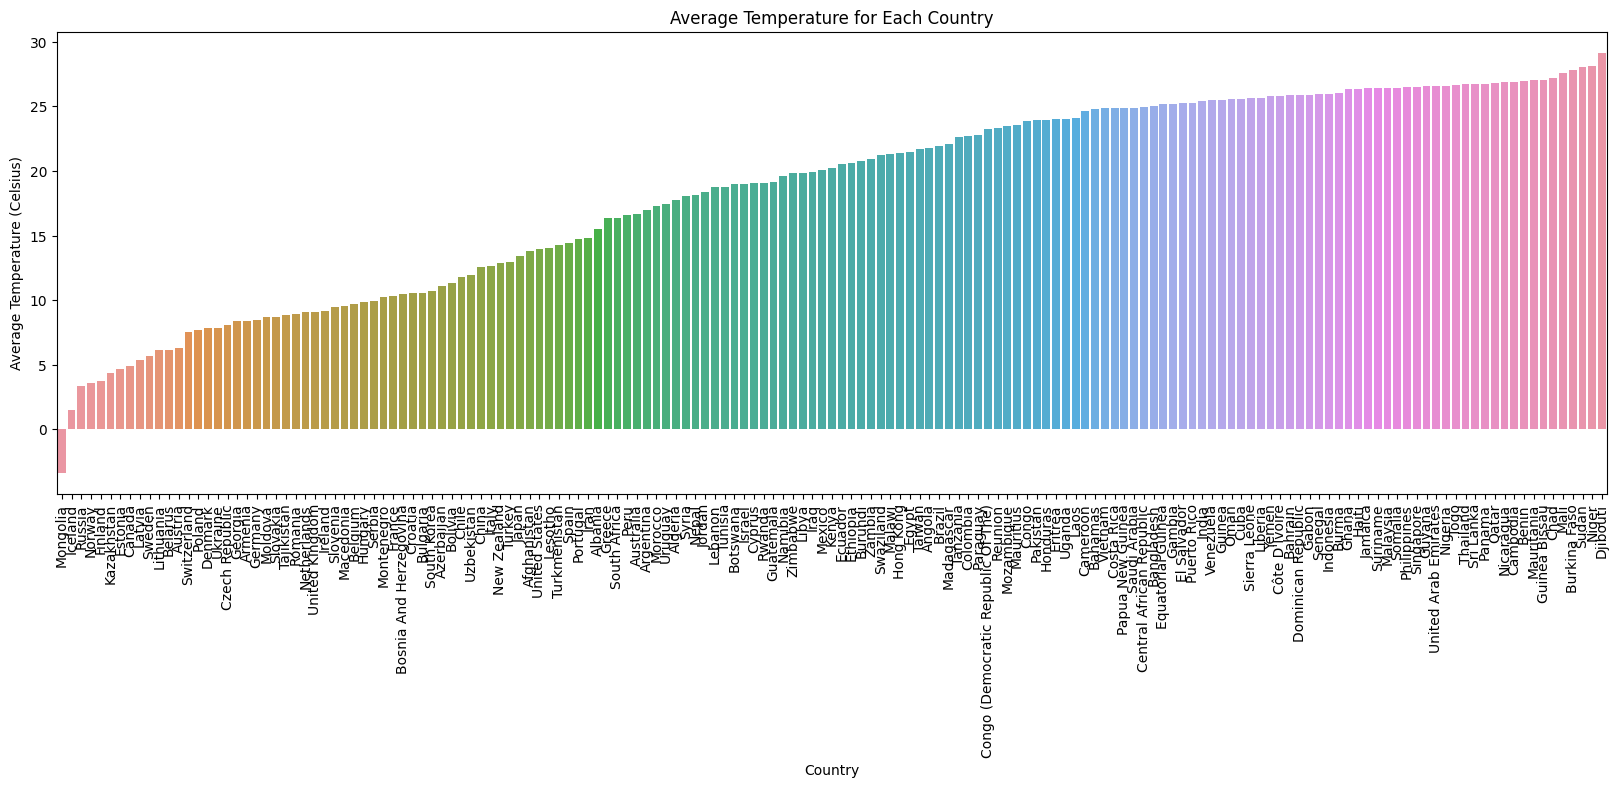

In [ ]:
country_temp_df = cleaned_temps_df.groupby('Country').mean().reset_index()
fig, ax = plt.subplots(figsize=(20, 6))
g = sns.barplot(data = country_temp_df.sort_values('AverageTemperature'), x = 'Country',y='AverageTemperature',errorbar=None)
plt.xticks(rotation=90)
plt.title('Average Temperature for Each Country')
plt.ylabel('Average Temperature (Celsius)')
plt.show

As evidenced above, temperatures tend to range a fair amount acoss countries. The majority, however, tend to have an average temperature of above 15 degrees Celsius.

Since our data ranges back to the mid-18th century, let's also visualize how average temperature uncertainty has changed as measurement techniques have evolved. To do so, a dataframe containing the average temperature within each year, rather than at the country-level, is first created.

<ipython-input-203-e9e9bc06bfd4>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_temp_df = cleaned_temps_df.groupby('Year').mean().reset_index()


<function matplotlib.pyplot.show(close=None, block=None)>

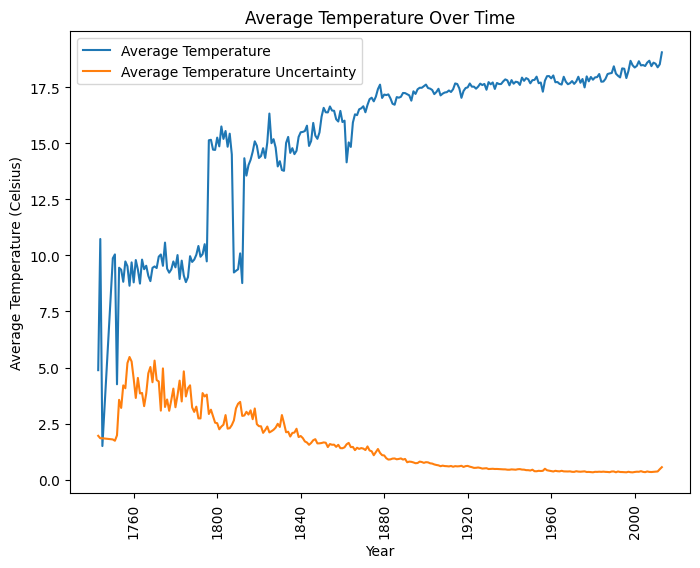

In [ ]:

yearly_temp_df = cleaned_temps_df.groupby('Year').mean().reset_index()
fig, ax = plt.subplots(figsize=(8, 6))
g = sns.lineplot(data = yearly_temp_df, x = 'Year',y='AverageTemperature', label = 'Average Temperature')
n = sns.lineplot(data = yearly_temp_df, x = 'Year',y='AverageTemperatureUncertainty', label = 'Average Temperature Uncertainty')
plt.xticks(rotation=90)
plt.title('Average Temperature Over Time')
plt.ylabel('Average Temperature (Celsius)')
plt.show

During earlier years in temperature measurements, there are higher levels of uncertainty. Therefore, for a majority of our analysis we will focus on dates post-1875, where there is less noise in the data. As shown by the low levels of uncertainty, we can be relatively confident in the accuracy of our temperature measurements for the remainder of our analysis.

This graph also reveals the extent to which temperatures have increased since 1750. Despite some fluctuations, there has been a notable rise in average temperature across all countries, with stabilization occuring in approximately the 1880s.

##Emissions Visualizations##

Next, let's visualize the emissions data. We can first use a correlation heatmap to determine whether the different sources of emissions are potentially connected and to ensure that we will have no issue of multicollinearity in our later analysis. 

<ipython-input-206-c0954dd9c98b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = sns.heatmap(cleaned_emissions_df.drop('Per Capita', axis = 1).corr(), cmap='RdBu', vmin = -1)


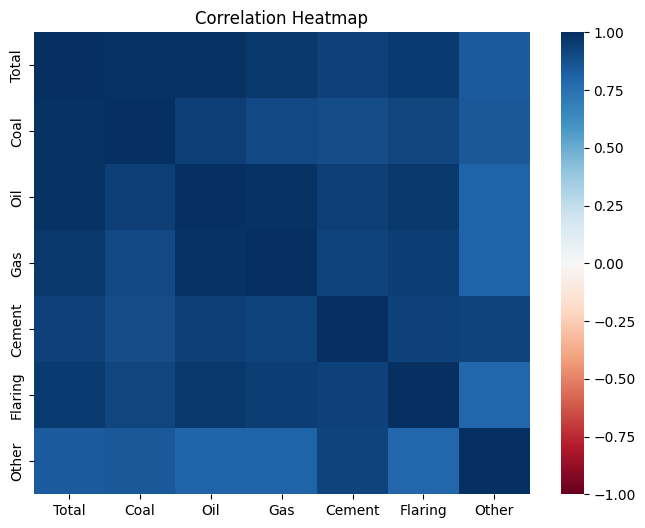

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
corr_mat = sns.heatmap(cleaned_emissions_df.drop('Per Capita', axis = 1).corr(), cmap='RdBu', vmin = -1)
plt.title('Correlation Heatmap')
plt.show()

Given by these results, we can conclude that there is an overall positive correlation between each of the given sources of emissions, with a particularly strong relationship between sources like oil and gas. This makes sense, as an industrious country is likely to have large amounts of all types of emissions, not just a single type.


Despite the correlation, as each represents a different source of carbon dioxide emissons all adding to the cumulative effect, **it will not be a source of multicollinearity** in the context of our analysis.

We then sought out to determine whether certain countries are responsible for a higher level of total emissions. As previously mentioned, this information could be useful in order to direct future reduction efforts. To visualize this, a dataframe containing total emissions per country over this time period is first created. 

In [ ]:
total_country_emissions_df = cleaned_emissions_df.groupby('Country').sum().reset_index()
total_country_emissions_df.describe()

<ipython-input-207-1dd77f9caa92>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_country_emissions_df = cleaned_emissions_df.groupby('Country').sum().reset_index()


,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
count,2.320000e+02,2.320000e+02,2.320000e+02,2.320000e+02,2.320000e+02,232.000000,232.000000,232.000000
mean,5.567870e+05,3.257897e+05,1.619281e+05,5.378448e+04,8.773584e+03,4670.789840,1413.671982,360.944624
std,4.466312e+06,2.623006e+06,1.301555e+06,4.472422e+05,6.867994e+04,36489.714199,10908.931222,884.359035
min,3.997424e+00,0.000000e+00,2.088480e-01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,8.234195e+02,0.000000e+00,6.072015e+02,0.000000e+00,0.000000e+00,0.000000,0.000000,30.889269
50%,7.162540e+03,1.267126e+02,4.406417e+03,8.497742e+00,2.811656e+02,0.085984,0.000000,135.176626
75%,7.923003e+04,1.463623e+04,3.716345e+04,6.482503e+03,2.233410e+03,261.169992,0.000000,410.267616
max,6.458729e+07,3.779207e+07,1.879169e+07,6.239001e+06,1.017860e+06,542213.928755,123517.934274,11574.339869


There is, however, a significant range in total emissions across the different countries contained in the dataset. As shown above, the minimum value of total emissions is just 0.153888, while the maximum is over 1,736,930. As such, **we will then restrict our area of focus to the countries with a higher level of total emissions than the average emitter in the dataset**. The row containing total emissions on a global level will also be dropped, as we want to investigate the individual effects of different emissions on the temperature of each country, not emissions as a whole.

In [ ]:
mean_emissions = total_country_emissions_df['Total'].mean()
top_country_emissions_df = total_country_emissions_df[total_country_emissions_df['Total'] > mean_emissions]
top_country_emissions_df = top_country_emissions_df[top_country_emissions_df['Country'] != 'Global']

Before we visualize this, let's quickly check who our top emitters are for later analysis.

In [ ]:
top_country_emissions_df.sort_values('Total', ascending = False).head(4)

,Country,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
218,USA,1.949657e+07,1.047078e+07,6.158763e+06,2.636753e+06,110184.897387,73199.647950,46888.538776,2252.097216
222,United Kingdom,6.240797e+06,5.563917e+06,4.847487e+05,1.588088e+05,23173.029063,8128.770298,1959.764200,1645.530351
77,Germany,5.393605e+06,4.527826e+06,6.455133e+05,1.647707e+05,48673.075333,1738.442773,5083.954162,1311.383670
41,China,4.473565e+06,3.507456e+06,5.876063e+05,7.261415e+04,202958.888743,1522.591954,101406.842315,202.362414


<function matplotlib.pyplot.show(close=None, block=None)>

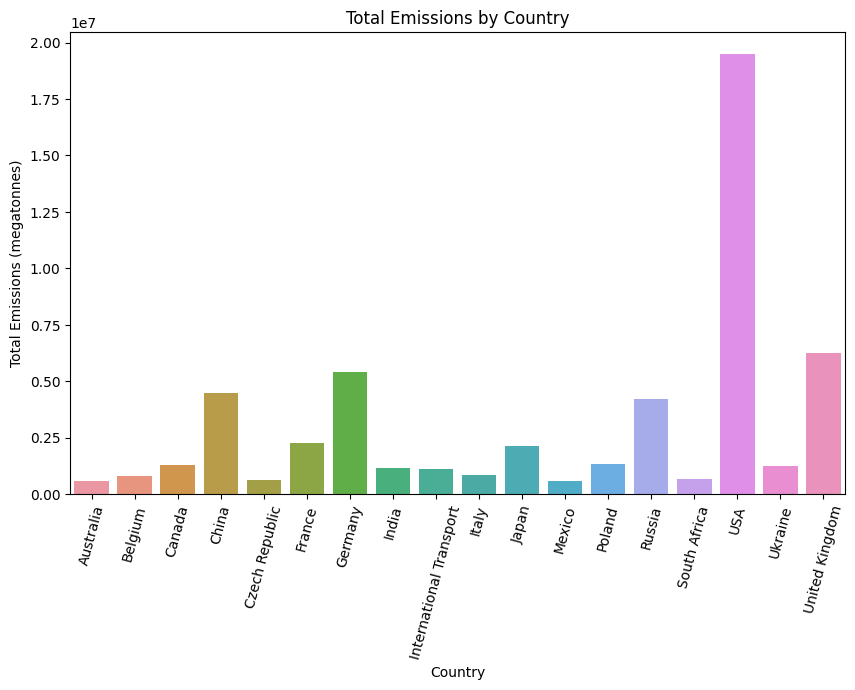

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
g = sns.barplot(data = top_country_emissions_df, x = 'Country',y='Total',errorbar=None)
plt.xticks(rotation=75)
plt.title('Total Emissions by Country')
plt.ylabel('Total Emissions (megatonnes)')
plt.show

Several countries emerge as top emitters, with carbon dioxide emission levels far surpassing those of the vast majority of other countries. This provokes an interesting question of whether the responsibility for addressing the climate-related impacts of emissions should fall on certain countries more than others, as regional discrepancies clearly play a role.

We then wondered whether the top-emitters have experienced an increasing in total emissions in recent decades. If so, we may be able to draw a comparison to increasing temperatures in recent years. 

We will then create a dataframe storing the emissions data for just China, the USA, Russia, and Japan - our top emitters - after 1975. A `Cleaned Year` column is also created to store the year value of each observation for easier visualization.

In [ ]:
top_emitters_data = cleaned_emissions_df[cleaned_emissions_df['Year'] >= pd.to_datetime(1975, format='%Y')]
top_emitters_data = top_emitters_data[top_emitters_data['Country'].isin(['China', 'USA', 'Germany', 'China'])]
top_emitters_data['Cleaned Year'] = top_emitters_data['Year'].apply(lambda x : x.year)

<function matplotlib.pyplot.show(close=None, block=None)>

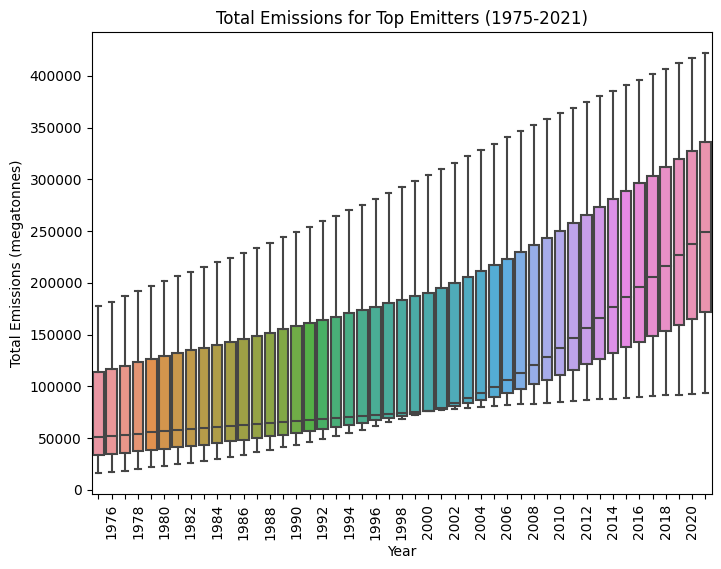

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data = top_emitters_data, x = 'Cleaned Year', y='Total')
plt.xticks(rotation=90)
plt.title('Total Emissions for Top Emitters (1975-2021)')
plt.xlabel('Year')
plt.ylabel('Total Emissions (megatonnes)')
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
plt.show

When considering the median emissions level for our top emitters, it seems as though **total emissions increased gradually at first, with a dramatic upward trend appearing in the early 2000s**. As represented by the max point of each box above, the **top-emitting country has steadily increased its total emissions throughout the duration of this time period**. 


This may be of concern, as **it implies that the human impact on climate as a result of emissions will likely continue to increase in coming years if this pattern persists**.

We then chose to visualize total carbon dioxide emissions of all countries on a yearly basis to confirm that emissions have increased, as a whole, in recent decades. 

<ipython-input-261-1ed7b399e772>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  total_emissions_df = cleaned_emissions_df.groupby(by = 'Year').sum().reset_index()


<function matplotlib.pyplot.show(close=None, block=None)>

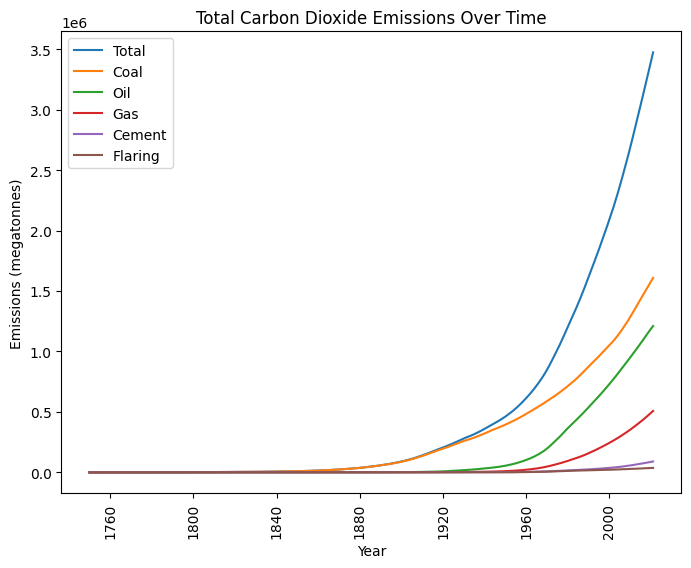

In [ ]:
total_emissions_df = cleaned_emissions_df.groupby(by = 'Year').sum().reset_index()
fig, ax = plt.subplots(figsize=(8, 6))
t = sns.lineplot(data = total_emissions_df, x = 'Year',y='Total',label='Total')
c = sns.lineplot(data = total_emissions_df, x = 'Year',y='Coal', label='Coal')
o = sns.lineplot(data = total_emissions_df, x = 'Year',y='Oil', label='Oil')
g = sns.lineplot(data = total_emissions_df, x = 'Year',y='Gas', label='Gas')
ce = sns.lineplot(data = total_emissions_df, x = 'Year',y='Cement', label='Cement')
f = sns.lineplot(data = total_emissions_df, x = 'Year',y='Flaring', label='Flaring')
plt.xticks(rotation=90)
plt.ylabel('Emissions (megatonnes)')
plt.title('Total Carbon Dioxide Emissions Over Time')
plt.show

The plot reveals there to have been a **sharp increase in total emissions, as well as in emissions from all sources, beginning in approximately the 1950s**. 

The proportion of each source of emission's contribution to total emissions over time can also be easily visualized. The effect of each source on total emissions is comprable, given that each observation is measured in megatonnes of carbon dioxide. Evidently, **coal and oil have the most significant impact**, with other sources increasing less dramatically over this time period. 

Having revealed the extent to which emissions have increased in recent years, we wanted then to provide a quantifiable measure of this trend. To do so, we extracted the cumulative total emissions value from 1990 and from the most recent observation in 2021. 

In [ ]:
since_1990 = total_emissions_df[total_emissions_df['Year'] == pd.to_datetime(1990, format='%Y')]

current_df = total_emissions_df[total_emissions_df['Year'] == pd.to_datetime(2021, format='%Y')]

since_1990['Total'].sum() / current_df['Total'].sum()

0.46528658291253494

As shown, **almost half of all carbon dioxide emissions since 1750 have been emitted in the last 30 years**. This figure reflects the failures of the global community to improve reduction efforts, despite increased warnings from scientific communities regarding the potential impacts. Emissions have not only not been reduced, but they have continued to increase.

# **Baseline ML Model**

In creating our first model, we consider the effect of emissions on temperature by individual country: each country will have its own, one-hot encoded value that acts as a constant baseline representing temperature by country.

In [ ]:
# Merge temp and emission data
temp_emissions_df = country_temps.merge(cleaned_emissions_df, how = 'inner',left_on = ['Country', 'Year'], right_on = ['Country', 'Year'])

# Fill all missing values with 0; makes sense, as unreported emissions may be considered negligible and early years already had neglible emissions
temp_emissions_df = temp_emissions_df.fillna(0)
temp_emissions_df = temp_emissions_df.drop_duplicates()
# drop first = true for linear regression comparison

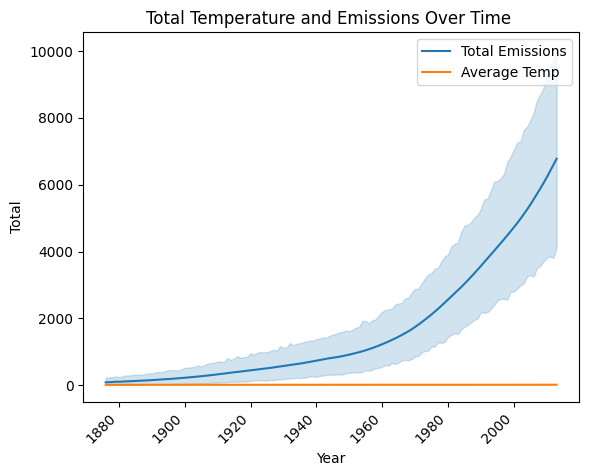

In [ ]:
import datetime
from sklearn.preprocessing import StandardScaler

subset = temp_emissions_df[temp_emissions_df['Year'] > pd.to_datetime(1875, format='%Y')]
#scale the data
scaler = StandardScaler()
subset = subset.set_index(['Year','Country'])
scaler.fit(subset)
scaler.transform(subset)
sns.lineplot(x="Year", y="Total", data=subset, label = "Total Emissions")
sns.lineplot(x="Year", y="AverageTemperature", data=subset, label = "Average Temp")
# set label
plt.legend()
plt.title("Total Temperature and Emissions Over Time ")
plt.xticks(rotation=45, ha="right")
plt.show()

The graph above displays that despite the large increases in emssions, there is very little noticeable effect on temperature visually, which will be important in the interpretation of our final model.

Below, each country is one-hot encoded, with the first country being dropped to prevent the effect of perfectly collinear attributes in our model.

In [ ]:
subset = subset.reset_index()
features_onehot = subset[['Year','Country','Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Other']]
target = subset['AverageTemperature']

In [ ]:
# One hot encoding to allow for different countries // Compute year on year change 
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(features_onehot[['Country']]).toarray())
final_features = features_onehot.join(encoder_df)
final_features.columns = final_features.columns.astype(str)

In [ ]:
# Rename values to make more interpretable
country_names = subset['Country'].unique()
index = list(range(0,subset['Country'].nunique()))
for i in index:
  i_str = str(i)
  name = country_names[i]
  final_features.rename(columns = {final_features.columns[i+8] : name}, inplace = True)

In [ ]:
# Note that Country, Year and the one-hot encoded random value are dropped
final_features = final_features.drop(['Algeria', 'Year', 'Country'], axis =1)

In [ ]:
seed = 90
X_train, X_test, y_train, y_test = train_test_split(final_features, target, test_size=0.20, random_state=seed)

In [ ]:
# Run regression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse_score = sklearn.metrics.mean_squared_error(y_pred,y_test)
reg_score = r2_score(y_test,y_pred)
print(reg_score)
print(mse_score) # Works well... Maybe too well?

0.993876964374932
0.3466285035429311


In [ ]:
# View magnitude of all coefficients
coefficients = pd.concat([pd.DataFrame(final_features.columns),pd.DataFrame(np.transpose(reg.coef_))], axis = 1)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(coefficients)

                            0          0
0                        Coal  8.302e-06
1                         Oil  8.254e-05
2                         Gas -3.172e-05
3                      Cement  1.723e-04
4                     Flaring  1.058e-03
5                       Other -6.680e-04
6                 Afghanistan -3.844e+00
7                     Albania -2.077e+00
8                      Angola  3.950e+00
9                   Argentina -8.849e-01
10                    Armenia -9.156e+00
11                  Australia -9.992e-01
12                    Austria -1.139e+01
13                 Azerbaijan -6.446e+00
14                    Bahamas  7.122e+00
15                    Bahrain  8.173e+00
16                 Bangladesh  7.441e+00
17                    Belarus -1.151e+01
18                    Belgium -7.976e+00
19                      Benin  9.209e+00
20                    Bolivia -6.397e+00
21                   Botswana  1.232e+00
22                     Brazil  4.110e+00
23              

R-Squared : **0.993876964374932**

MSE : **0.3466285035429311**

The R-Squared value measures how much variability in the dependent variable is explained by the model, while the MSE measures how much the predict result tends to deviate from actual values.


While the model performs extremely well according to our regular regression accuracy metrics, the interpretation is not suitable for our analysis. For one, the regression has not attributed the effect of increasing temperature majorly to our emitters, which are extremely small values and even negative for some. **It has entirely isolated the effect of temperature based on a given country**.

This makes this regression inherently biased. While the variation explained is extremely high with all countries one-hot encoded, it is enough to answer our main question, which is **how emissions affect the temperature of a given country**.

<ipython-input-223-b18ba79ea5f8>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual)


Text(0.5, 1.0, 'Residual Plot')

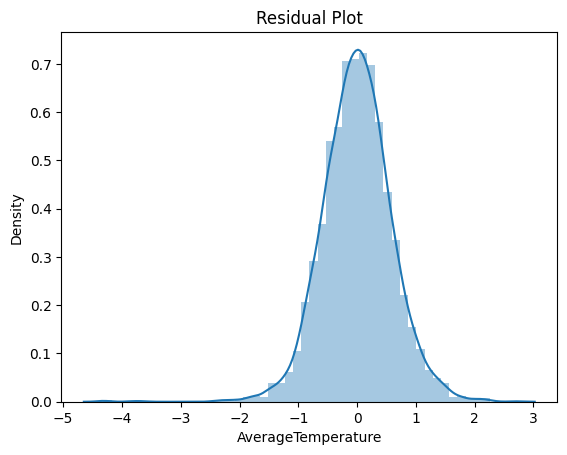

In [ ]:
residual=y_test-y_pred
sns.distplot(residual)
plt.title("Residual Plot")

The above plot proves how well the model predicts emissions by plotting the residuals.

Despite this, we will attempt **to utilize unsupervised methods to reduce the dimensionality of our data to isolate the effect of emissions on temperature in a supervised model**.

#**Unsupervised Learning**# 

Moving forward, we will need to find a new way to account for baseline temperature of different countries in order to reduce the dimensionality of our dataset.

### **K-Means Clustering**

While each country is likely to have their won subtle differences in temperature due to altitude amongst other attributes, there is a single determinant that accounts for temperature differences in the world that we have already included: **latitude**.

We will use a **K-Means Clustering algorithm to cluster models of similar latitude, and therefore similar temperature**. This will solve our issue with dimensionality and allow us to investigate unsupervised models discussed in lecture.

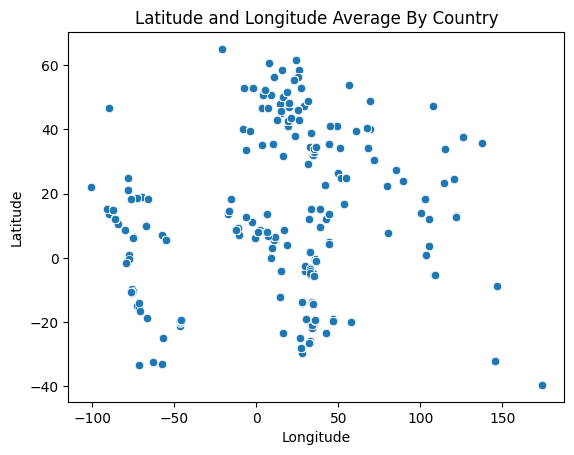

In [ ]:
# Cannot adequately use lat / long data in regression due to its scale (not ordinal)
# Group by k means clustering as a metric for countries with similar temperatures
sns.scatterplot(x="Longitude", y="Latitude", data= subset)
# set label
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("Latitude and Longitude Average By Country")
plt.show()

This graph displays the orientation of our countries by the average of their included cities' longitude and latitude values *(notice how the graph looks like an actual map!)*.

We will display a revised version of this plot with the newfound latitude cluster labels after the algorithm is computed.

In [ ]:
country_temps_k = subset[['AverageTemperature', 'Latitude']]

<Figure size 640x480 with 0 Axes>

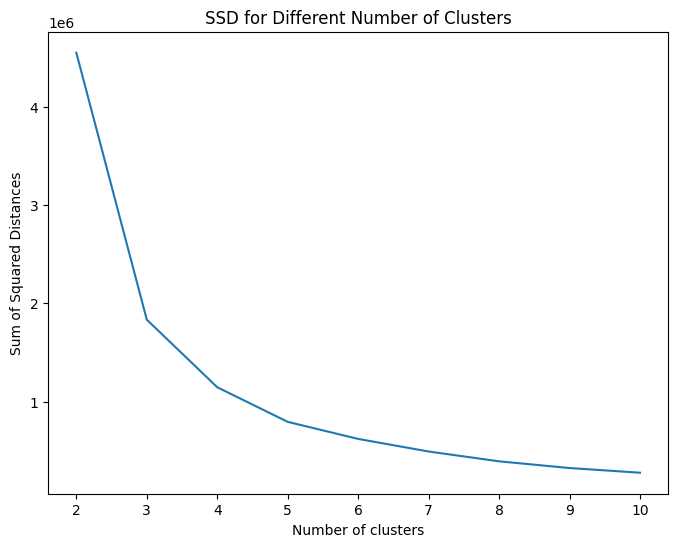

In [ ]:
from sklearn.cluster import KMeans

ssd = {}
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, n_init = 5, random_state=0).fit(country_temps_k)
  ssd[k] = kmeans.inertia_
plt.figure()
plt.figure(figsize = (8, 6))
plt.plot(list(ssd.keys()), list(ssd.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Sum of Squared Distances")
plt.title("SSD for Different Number of Clusters")
plt.show()

With the subset temperatures, k = 4 is chosen as the number of clusters given the definitive "knee" present at that value in the graph.

In [ ]:
# Optimal number of clusters is 3 according to the elbow plot
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(country_temps_k) # Compute k-means clustering.
country_temps_k['cluster_label'] = kmeans.fit_predict(country_temps_k)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-227-147563c249d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_temps_k['cluster_label'] = kmeans.fit_predict(country_temps_k)


In [ ]:
# Merge back with other
subset['cluster_label'] = country_temps_k['cluster_label']

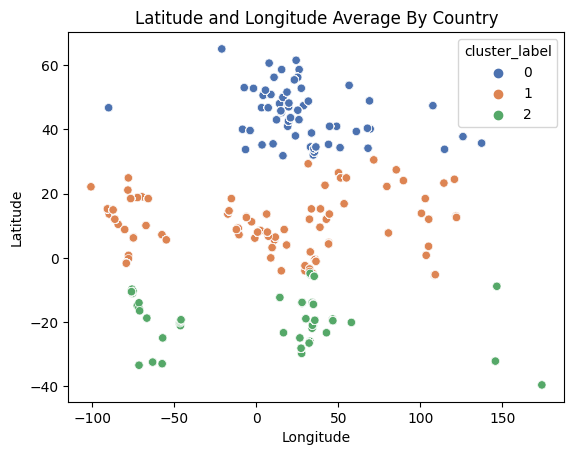

In [ ]:
sns.scatterplot(x="Longitude", y="Latitude", data= subset, hue = 'cluster_label', palette="deep")
# set label
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("Latitude and Longitude Average By Country")
plt.show()

In [ ]:
cluster_df = subset.groupby(['cluster_label', 'Year']).mean().reset_index()
cluster_df['Year'] = cluster_df['Year'].dt.year
cluster_df

<ipython-input-230-da2ff2c4f9eb>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_df = subset.groupby(['cluster_label', 'Year']).mean().reset_index()


,cluster_label,Year,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,Total,Coal,Oil,Gas,Cement,Flaring,Other,Per Capita
0,0,1876,10.335458,1.145095,44.706032,28.809533,226.378276,226.062467,0.282040,0.000000,0.000000,0.000000,0.000000,0.394347
1,0,1877,10.420525,1.273630,44.706032,28.809533,235.558376,235.181885,0.342721,0.000000,0.000000,0.000000,0.000000,0.386120
2,0,1878,10.799087,1.068705,44.706032,28.809533,244.847037,244.404266,0.409000,0.000000,0.000000,0.000000,0.000000,0.387212
3,0,1879,10.196521,1.022405,44.706031,28.808616,254.441796,253.947629,0.487572,0.000000,0.000000,0.000000,0.000000,0.399317
4,0,1880,10.276572,0.978410,44.706032,28.809533,265.278333,264.682524,0.568573,0.000000,0.000000,0.000000,0.000000,0.486663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,2,2009,19.718620,0.497476,-22.166208,19.234568,2385.358850,1152.366779,942.513683,188.781434,53.846537,40.317349,7.533070,2.794457
410,2,2010,19.974615,0.490638,-22.166208,19.234568,2461.769572,1182.533937,972.893546,199.906487,55.730197,42.709060,7.996346,2.796879
411,2,2011,19.663237,0.525056,-22.166208,19.234568,2539.686984,1212.629815,1004.906736,211.260215,57.700942,44.710595,8.478680,2.816485
412,2,2012,19.815470,0.592576,-22.166208,19.234568,2619.077777,1242.931377,1037.948603,223.333714,59.815104,46.093390,8.955590,2.857735


<function matplotlib.pyplot.show(close=None, block=None)>

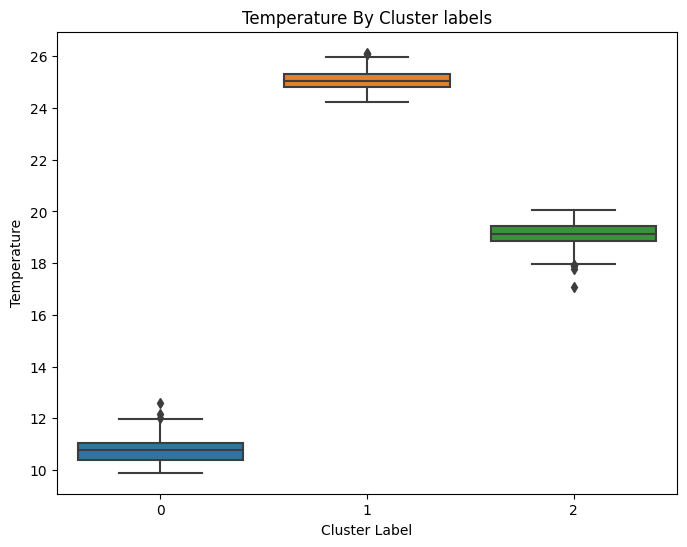

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data = cluster_df, x = 'cluster_label', y='AverageTemperature')
plt.title('Temperature By Cluster labels')
plt.xlabel('Cluster Label')
plt.ylabel('Temperature')
plt.show

As shown above, this feature **perfectly captures the effect of latitude on temperature with lower dimensionality**: the most northern cities have the coolest climate, those closest to the equator have the warmest climate, while those below the equator, which are not quite as deep south as the northern countries are deep north, are more temperate.

#**Supervised Learning**#


##Linear Regression 

In this section, we will now focus our efforts on utilizing our given features to generate the machine learning model with most accurate output. We will first use linear regression as our baseline, then move to more complex algorithms. Our goal will be to predict temperature from carbon dioxide emissions.

Our feature attributes will therefore be the different sources of emissions, while the AverageTemperature column is the label. The data is split into training and testing sets with a size of 80% and 20% respectively.

In [ ]:
# isolate features and target
features = subset[['Coal', 'Oil', 'Gas', 'Cement', 'Flaring', 'Other', 'cluster_label']]
target = subset['AverageTemperature']

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(features[['cluster_label']]).toarray())
features = features.join(encoder_df)
features.columns = features.columns.astype(str)
features = features.drop("cluster_label", axis =1)

In [ ]:
features.rename(columns = {'0' : 'Middle',
                           '2' : 'Lower',
                           '1' : 'Upper'}, inplace = True)
# Drop for multicollinearity prevention
features = features.drop(columns = 'Upper')

In [ ]:
# Split into training and test features
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
seed = 90
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=seed)

In [ ]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Run regression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse_score = sklearn.metrics.mean_squared_error(y_pred,y_test)
reg_score = r2_score(y_test,y_pred)
print(reg_score)
print(mse_score) #MSE is 15

0.7391045937097491
14.76943624064089


In [ ]:
# View magnitude of all coefficients
coefficients = pd.concat([pd.DataFrame(features.columns),pd.DataFrame(np.transpose(reg.coef_))], axis = 1)
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(coefficients)

         0          0
0     Coal -7.905e-05
1      Oil -9.718e-05
2      Gas -3.831e-04
3   Cement  3.481e-03
4  Flaring  4.131e-03
5    Other -1.724e-03
6   Middle -1.417e+01
7    Lower -5.916e+00


<ipython-input-238-b18ba79ea5f8>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual)


Text(0.5, 1.0, 'Residual Plot')

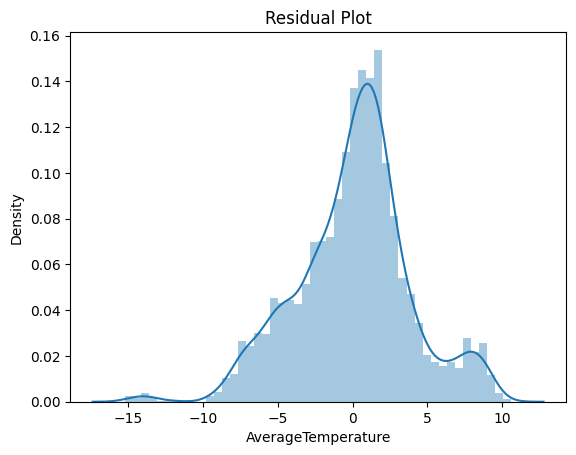

In [ ]:
residual=y_test-y_pred
sns.distplot(residual)
plt.title("Residual Plot")

R-Squared : **0.7493302790237629**

MSE : **14.69286896772483**

The effect of this new model is understandably less accurate than the previous model with a surplus of attributes, leading to a lower R-Squared value.  

However, **the interpetability has increased**: the new coefficents are of higher magnitude. Despite this, the effects of different emitters are not constant as we predicted, nor totally positive. The less common emitters are given higher weights, potentially as an indication that although the effect is negligible for most countries, those with less common emmiters have higher temperatures due to the increased amount of carbon dioxide in the atmosphere. This makes sense, as only the countries with the greatest amount of emissions have 'Flaring' and 'Cement' emissions.

This likely is due to **the relative small size of our dataset**, the fact that **we are evaluating carbon dioxide's effect on individual countries while it may have spread** across the globe, or simply due to **carbon dioxide not having a noticeable effect on changing temperature** as is.

Nevertheless, we will attempt more complex algorothms to increase our accuracy.

##Decision Tree
We will next use a continuous Decision Tree regressor to isolate the effects of emissions on temperature. With its easy-to-understand quality and ability to visualize, it makes sense as a follow-up to our regression.

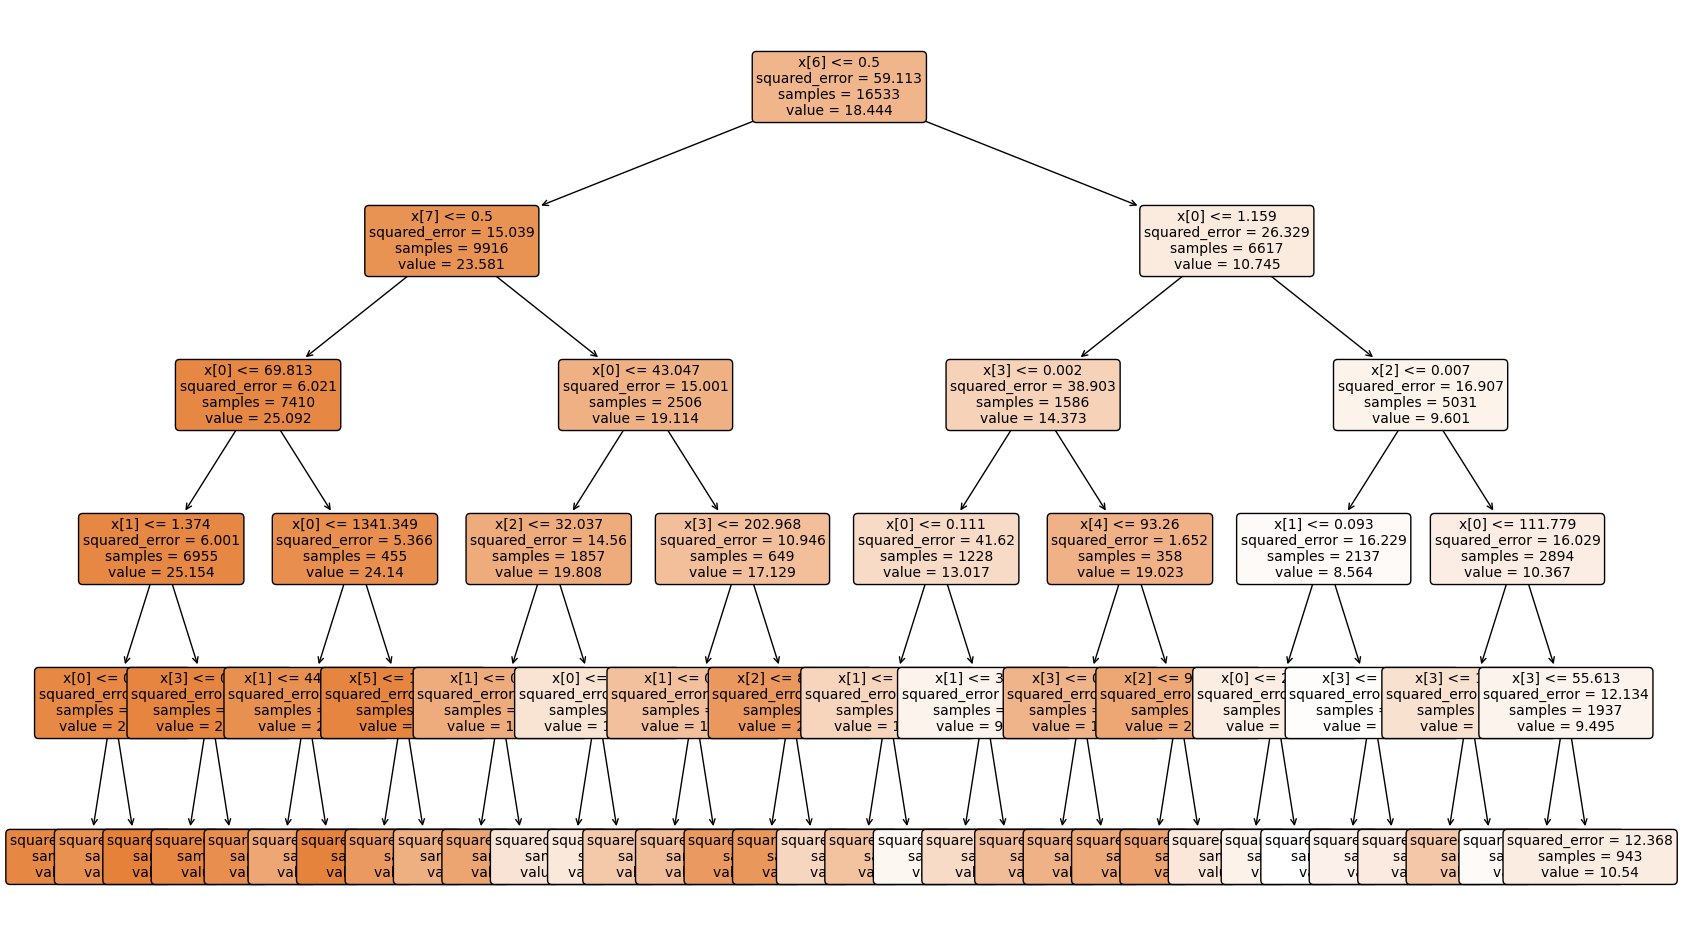

In [ ]:
from sklearn import tree
from sklearn.metrics import mean_squared_error
clf = tree.DecisionTreeRegressor(max_depth=5)
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(20,12))
tree.plot_tree(clf, filled=True,rounded=True, fontsize = 10)
plt.show()

In [ ]:
y_pred = clf.predict(X_test)

rfr_score = r2_score(y_test, y_pred)
mse_score = mean_squared_error(y_test, y_pred)

print(rfr_score)
print(mse_score)

0.8014776867204995
11.23846023208299


<ipython-input-241-b18ba79ea5f8>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual)


Text(0.5, 1.0, 'Residual Plot')

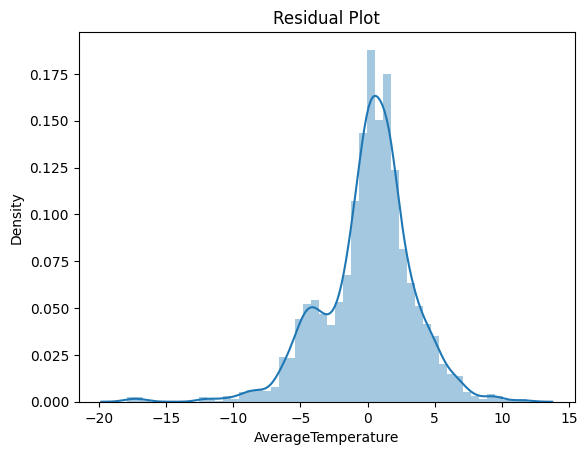

In [ ]:
residual=y_test-y_pred
sns.distplot(residual)
plt.title("Residual Plot")

R-Squared : **0.8074872624090035**

MSE : **11.284029108209072**

The Decision Tree algorithm noticeably raises our R-Squared value and reduces our mean squared error. Despite this, it is less interpretable than our other model, indicating that **the underlying issues with our dataset and interpretation still exist**.

##Random Forest

We will next use the Random Forest algorithm to investigate the effects of emissions on temperature. Its robust quality coupled with the ability to handle continuous data while minimzing bias make it an obvious choice to improve upon our decision tree. This is easily the next logical follow-up, as the Random Forest algorithm is used to improve decision tree outcomes through bagging!

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100,  random_state=seed)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rfr_score = r2_score(y_test, y_pred)
mse_score = mean_squared_error(y_test, y_pred)
print(rfr_score)
print(mse_score)
#score is higher than lin regression model

0.8773386061632116
6.94393075455344


<ipython-input-243-b18ba79ea5f8>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual)


Text(0.5, 1.0, 'Residual Plot')

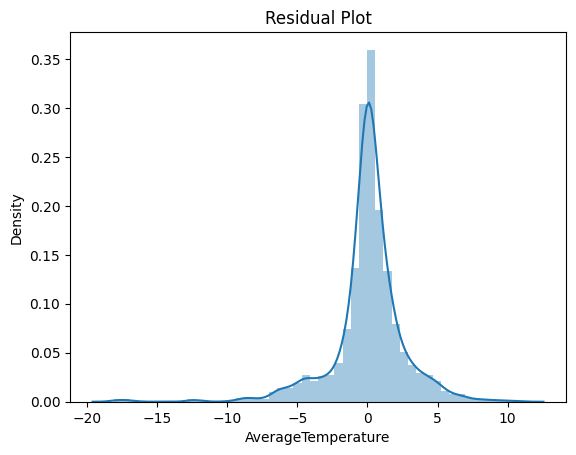

In [ ]:
residual=y_test-y_pred
sns.distplot(residual)
plt.title("Residual Plot")

R-Squared : **0.8742253950044172**

MSE : **7.372209868309668**

The Random Forest algorithm noticeably raises our R-Squared value and reduces our mean squared error. Despite this, it is still less interpretable than our other model, indicating that **the underlying issues with our dataset and interpretation still exist**.

##XGBoost

As a comparison with Random Forest, we will additionally employ the XGBoost model for our predictions. Given the fact that it employs boosting as opposed to bagging, it makes for an interesting analysis to see what best predicts temperature with emissions data.

In [ ]:
# evaluate an xgboost regression model on the housing dataset
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

# Create regression matrices
from sklearn.preprocessing import LabelEncoder
# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )



Mean MAE: 1.902 (0.055)


This model has a good CV score, meaning it is apt for predicting new values.

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse_score = mean_squared_error(y_test, y_pred)
print(rfr_score)
print(mse_score)

0.8773386061632116
7.544001417256653


<ipython-input-246-b18ba79ea5f8>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual)


Text(0.5, 1.0, 'Residual Plot')

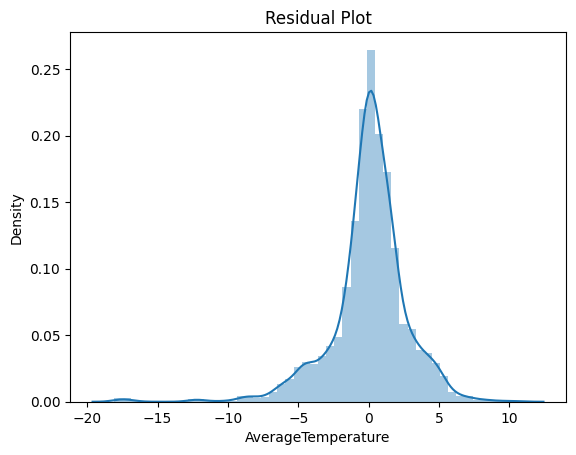

In [ ]:
residual=y_test-y_pred
sns.distplot(residual)
plt.title("Residual Plot")

R-Squared : **0.8074872624090035**

MSE : **7.7400571945997605**

The **XGBoost model does not predict quite as well as the Random Forest model**, although its automatic pruning and parameter evaluation may make it more apt for predicting the effect of emissions on future temperature values, as it is **less likely to overfit**.

#**Time Series Data**

To understand how the temperature has changed over time we can run a time series analysis. Additionally we can use an ARIMA model to forcefast future values from past values. We will look at the average temperature worldwide during each year for this analysis.

First, we use a log transformation to flatten out to a linear relationship. Then, we look at the rolling mean of the data to visualize if the data is stationary. From the graph below, we can see that the rolling mean indicates an overall increasing trend.

<ipython-input-247-a0c63a08d9c2>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_temp_emissions_df = temp_emissions_df.groupby('Year').mean().reset_index()


Text(0, 0.5, 'Temperature')

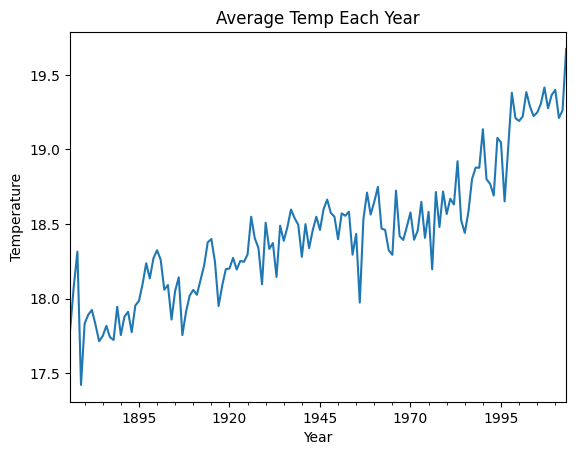

In [ ]:
# Read as a dataframe, convert date entries to the index, get the average temp for each year
yearly_temp_emissions_df = temp_emissions_df.groupby('Year').mean().reset_index()
#filter dates after 1875 to remove temp data with high noise from model
subset_yr_temp = yearly_temp_emissions_df[yearly_temp_emissions_df['Year'] > pd.to_datetime(1875, format='%Y')]
#set index to year and pull
subset_yr_temp = subset_yr_temp.set_index(['Year'])
series = subset_yr_temp['AverageTemperature']
series.plot()
plt.title('Average Temp Each Year')
plt.ylabel('Temperature')


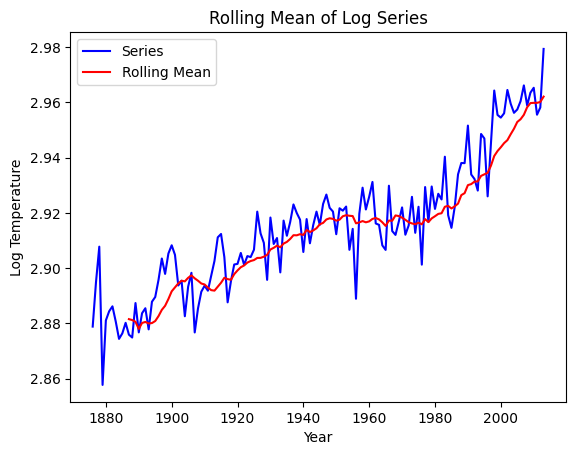

In [ ]:
#convert to log series to stablize 
log_data = np.log(series)
rolling_mean = pd.Series.rolling(log_data,center=False,
  window=12).mean()
rolling_std = pd.Series.rolling(log_data,center=False,
 window=12).std()
 
#plot rolling mean of log data
plt.plot(log_data,color='blue',label='Series')
plt.plot(rolling_mean,color='red', label='Rolling Mean')
plt.title('Rolling Mean of Log Series')
plt.ylabel('Log Temperature')
plt.xlabel('Year')
plt.legend()

Now, we want to run the Augmented Dickey Fuller (ADF) test to determine whether the series is stationary. This tests the null hypothesis that the time-series is non-stationary. Our result returns a high p-value (0.97) we we cannot reject the null. 

In [ ]:
#check for stationarity and Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
#looking for d parameter (how much differentiate)

result = adfuller((log_data))
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

# p value so this suggests  our time series is not stationary

ADF Statistic: -0.25577514849801786
p-value: 0.9315385433235323


Since we cannot reject the null hypothesis, we must difference the data. Once we difference the data, the p-value is less than 0.05 so we can confidently reject the null hypothesis. From the graph of the differenced data, we can clearly see that this series is now stationary.

p-value: 4.7815709470277675e-20


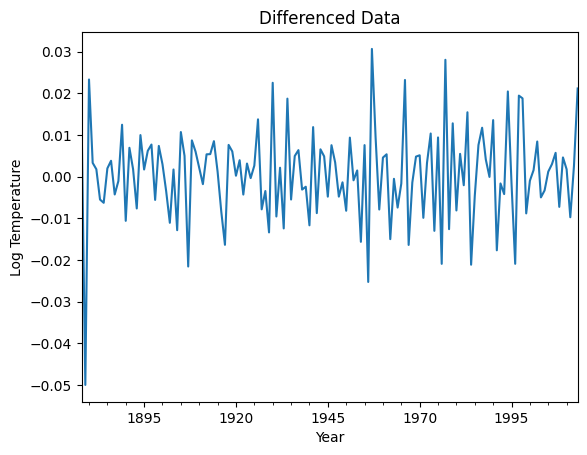

In [ ]:
#dampen the trend by differencing 
series_diff = log_data.diff().dropna()
#remove the first value from the list since differencing causes this value to be 0
series_diff = series_diff[1:]
series_diff.plot()
plt.title('Differenced Data')
plt.ylabel('Log Temperature')
adf_test = adfuller(series_diff)
print(f'p-value: {adf_test[1]}')
#now p value is less than 0.05 so we can reject null
#so we know d = 1

To forecast using the ARIMA model, we next need to determine the values of p (lags of the dependent variable) and q (lagged forecast errors in prediction equation). We can do this by graphing the partial autocorrelation and autocorrelation plots. The number of points that lie outside the confidence interval determines these values. 

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


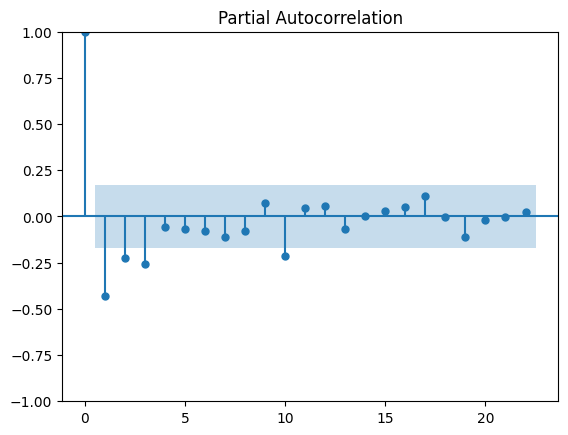

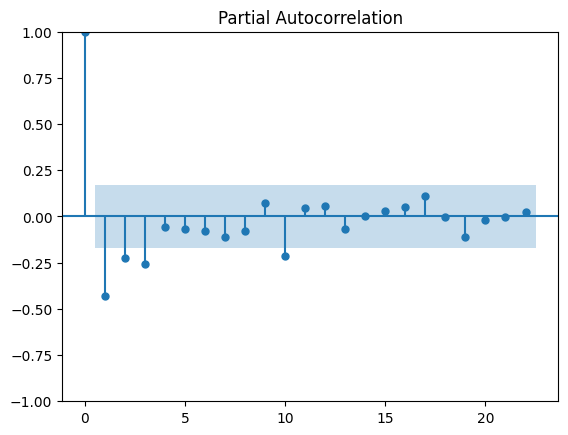

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

#plot partial autocorrelation to determine value for p
plot_pacf(series_diff)
#we can assign p to be 4 because 4 lie outside the signficance level 

Text(0.5, 0, 'hi')

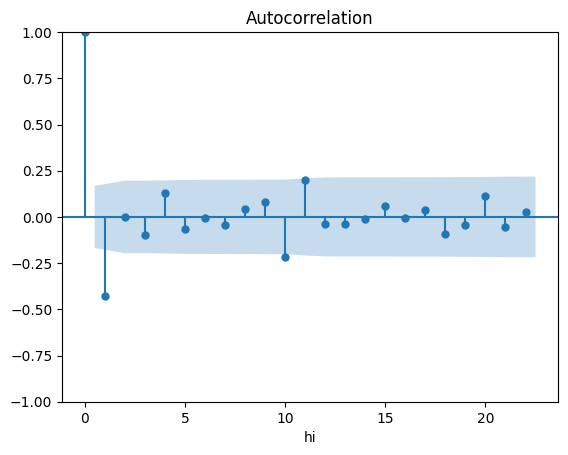

In [ ]:
#plot the auto correlation graph to determine q

plot_acf(series_diff)
# q =1

Now we can run the ARIMA model with p = 4, d = 1 and q = 1. This ultimately gives us an RSS score of 0.0127.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'RSS: 0.0127')

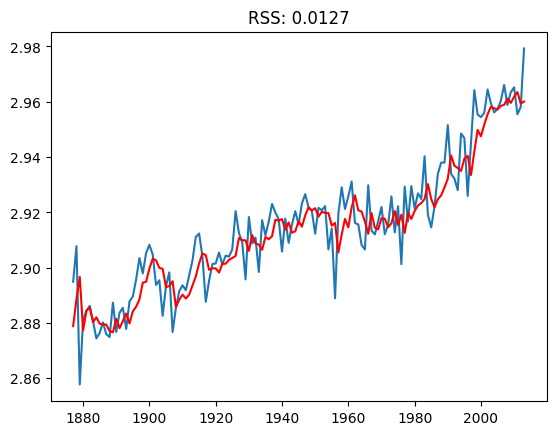

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#run arima model on the values p = 4, d = 1 and q = 2 
model = ARIMA((log_data), order = (4, 1, 1))
model_fit = model.fit()
#remove first value of 0 from differenced list
final_fit = (model_fit.fittedvalues[1:])
#plot the predicted values agaisnt the log vlaues
plt.plot(log_data[1:])
plt.plot(final_fit, color = 'red')
#calculate Rss
plt.title('RSS: %.4f'%sum((final_fit - log_data[1:])**2))
plt.ylabel('Log Temperature')
plt.xlabel('Year')
# low level of RSS

In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     AverageTemperature   No. Observations:                  138
Model:                 ARIMA(4, 1, 1)   Log Likelihood                 442.812
Date:                Wed, 26 Apr 2023   AIC                           -873.624
Time:                        23:58:08   BIC                           -856.104
Sample:                    01-01-1876   HQIC                          -866.504
                         - 01-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0219      0.746      0.029      0.977      -1.439       1.483
ar.L2         -0.0859      0.448     -0.192      0.848      -0.964       0.792
ar.L3         -0.0410      0.349     -0.118      0.906      -0.725       0.643
ar.L4          0.0860      0.261      0.330      0.741      -0.425       0.597
ma.L1         -0.6244      0.746     -0.837      0.402      -2.086       0.837
sigma2      9.084e-05    9.8e-06      9.273      0.000    7.16e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                28.38
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.73
Prob(H) (two-sided):                  0.80   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Using this model we can predict future temperature values. The graph below shows predictions for the next 15 years. 

In [ ]:
#predicting future values
data = pd.DataFrame()
data['log_data'] = log_data
#forecast for the next 15 years
future = pd.DataFrame(model_fit.forecast(15))
data = pd.concat([data, future])
data = data.rename(columns ={'predicted_mean':'forecasted year'})

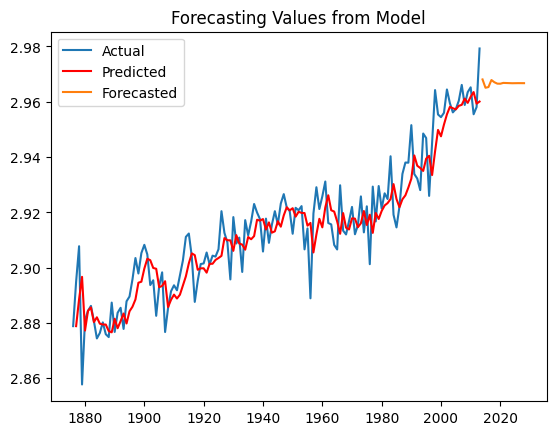

In [ ]:
plt.plot(data['log_data'], label='Actual')
plt.plot(final_fit, color = 'red', label = 'Predicted')
plt.plot(data['forecasted year'], label='Forecasted')
plt.legend()
plt.title('Forecasting Values from Model')
plt.show()

In [ ]:
data

,log_data,forecasted year
1876-01-01,2.878833,NaN
1877-01-01,2.894902,NaN
1878-01-01,2.907747,NaN
1879-01-01,2.857734,NaN
1880-01-01,2.881068,NaN
...,...,...
2024-01-01,NaN,2.966707
2025-01-01,NaN,2.966739
2026-01-01,NaN,2.966741
2027-01-01,NaN,2.966732


From the time series data, we found that the average temperature over the years was **not stationary**. The rolling mean demonstrated an upward trend. In order to run the ARIMA model, we had to differentiate the data and calculate the values of p and q. 

As seen in the plot of forecasted and predicted values, the **model follows a similar trend to the actual values**. This model produced a small RSS score of 0.0127.  **Forecasting for the next 15 years, the model predicted that the log temperature would spike and decrease in a similar fashion to previous values**, flattening out towards the end of the period.

In order to produce more accurate forecasted values, in future work we would like to run the ARIMA model on more data as well as separate countries by longitude and latitude rather than aggregating for all countries. Furthermore, if more time allowed, we would run similar ARIMA models on emissions data to compare their forecasted trends. 


# Conclusion

##Exploratory Data Analysis


Through our various visualizations, we were able to see how both temperature and emissions data has changed throughout the period contained by our datasets. 

In terms of temperature data, we noticed that there is a considerable range in temperatures across individual countries, but that the average temperature across *all* countries has increased between 1750-2021. 

Our emissions data suggested at additional trends in our data. We saw a positive correlation between the different sources of emissions, which corresponds to the notion that a country with high emission levels within a certain industry is more likely to have high emission levels in other, potentially related, industries. We then saw that several countries are responsible for an extremely significant share of total emissions globally, with emissions levels far surpassing those of other countries. The USA, China, Russia, and Japan emerged as our top-emitters, with a subsequent visualization revealing an alarming pattern; the emissions of these countries in particular have increased dramatically in recent decades. We then confirmed that this pattern held true when taking into account all countries, finding that there has been an increase in emissions from all sources since approximately the 1950s.

##Modeling

###Baseline Model

In our baseline model, we first considered the effect of emissions on temperature by individual country. To do so, we provided each country with a one-hot encoded value to act as a baseline. This model produced an R-squared of approximately 99% and an MSE of approximately 0.3. These metrics are extremely high, but the model is inherently biased, as it bases the effect on temperature on individual countries. This was an outcome we were able to predict with our visualization, which showed that large increases in emissions had little to no effect on temperature. 

###Linear Regression
The linear regression model performed decently, providing an R-Squared value of approximately 75% and a MSE of about 15. This can likely be explained by the fact that it contained less attributes than the previous model. Despite higher intepretability, the effects of different emissions sources were not constant, as we expected. This may be because countries that lack emissions from certain sources still have higher temperatures due to global emissions. 



###Decision Tree

The decision tree performed better than our linear regression model in terms of our regression metrics, with an R-squared value of approximately 81% and an MSE of approximately 11. The interpretability, however, is much weaker, since we are not able to see coefficients that measure the effect of each feature. Regardless, the ability to easily visualize the decision tree makes this a useful technique to include.

###Random Forest

The Random Forest performed even better than the decision tree in terms of our regression metrics, with an R-squared value of approximately 87% and an MSE of approximately 7. It maintains the same problem, however, of interpretability. Since we cannot see each tree produced by the algorithm, it is difficult to determine how each feature affects the outcome. 


###XGBoost

The XGBoost model provided weaker metrics than the Random Forest, with an R-squared value of approximately 81% and an MSE of approximately 8. Its underlying techniques, however, make it well-suited for predicting the effect of emissions on future temperature values by better avoiding the problem of overfitting. 

###Time Series
In our times series analysis, we found that differencing the data to address a lack of stationarity was necessary to then forecast temperatures for the next 15 years. Our forecasted results followed from trends in the past few decades. The model produced relatively low RSS score of 0.0127, which measures the amount of variance in the data that is not explaiend by the model itself.

##Next Steps
There are a number of improvements that could be made to our analysis in order to produce more robust results, as well as potential directions for future analysis. We detail several of them below.


*   A larger dataset might prove useful in strengthening the performance of our predictive models. Though we have enough observations to produce insightful results, access to more observations might improve our findings. 

*   With our time series data, it may have been better to separate countries by longitude and latitude rather than aggregating for all countries. This would have provided an additional layer of complexity that may have made our results more explicit. 

*   Throughout our analysis, we chose to predict temperatures from country-level emissions. The problem with this, however, is that carbon dioxide emissions do not remain in the country that they are emitted in. Instead, they spread and continue to have an impact on atmospheric conditions across many, if not all, countries. Future research might look to find a predictor of temperature that takes into account the distributed effect of emissions, potentially incorporating time-factors for the spread of carbon dioxide and its exact atmospheric effects. Of course, this is beyond the scope of our knowledge and ability, but it would be interesting to delve into further.  





##Significance

This project provided a rewarding opportunity to not only develop the skills we have learned in class, but also to increase our awareness of the pressing nature of climate changed and increased carbon dioxide emissions. Through our analysis, we are now better able to understand the extent to which individual countries contribute to the cumulative human impact on the environment. Further reduction efforts are certainly necessary, particularly for the countries that have emerged as being responsible for the vast majority of emissions. The dangers of human-induced climate change will only become more pressing in coming decades if past trends are any indication. Each stage of our analysis revealed the extent to which emissions have been on an upward trajectory in recent decades. As our collective carbon debt continues to accumulate, it will only become more difficult for individuals, policymakers, and governments to take effective action. As a global community, we cannot afford another decade of inaction. 